In [1]:
# Импортируем необходимые библиотеки
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import nltk
from collections import Counter
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.cuda.amp import GradScaler, autocast
import pickle
import gdown
import zipfile
import shutil


In [2]:
# Установим случайные начальные значения для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Проверим доступность GPU видеокарты
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [4]:
def download_data_from_gdrive():
    """Загружает и распаковывает zip архив с видеофайлами из Google Drive"""
    
    # Создаем директории
    os.makedirs("D:/video_to_text", exist_ok=True)
    
    print("Загружаем zip архив с видеофайлами...")
    # URL zip файла на Google Drive
    zip_url = 'https://drive.google.com/uc?id=1L7auAFyNnMUk8GFqQJYXoLXWxOVQD7HE&export=download'
    zip_path = 'D:/video_to_text/videos.zip'
    extract_path = 'D:/video_to_text/YouTubeClips'
    
    try:
        # Создаем директорию для распаковки
        os.makedirs(extract_path, exist_ok=True)
        
        # Скачиваем zip файл
        print('Скачиваем zip архив с Google Drive...')
        gdown.download(zip_url, zip_path, quiet=False)
        
        # Распаковываем архив
        print('Распаковываем архив...')
        extract_zip_flat(zip_path, extract_path)
        
        # Удаляем zip файл для экономии места
        if os.path.exists(zip_path):
            os.remove(zip_path)
            
        print('Готово! Видео распакованы в:', extract_path)
        
    except Exception as e:
        print(f"Ошибка при загрузке архива: {e}")
        return False
    
    # Загрузка файла описаний
    print("Загружаем файл с описаниями...")
    description_url = "https://drive.google.com/uc?id=13Qc0YfeotmttzUhA69MOSW42Ze-Jkhjm&export=download"
    description_path = "D:/video_to_text/AllVideoDescriptions.txt"
    
    try:
        gdown.download(description_url, description_path, quiet=False)
        print("Файл описаний загружен успешно!")
    except Exception as e:
        print(f"Ошибка загрузки файла описаний: {e}")
        return False
    
    return True

def check_and_download_data():
    """Проверяет наличие данных и загружает при необходимости"""
    video_dir = "D:/video_to_text/YouTubeClips"
    caption_file = "D:/video_to_text/AllVideoDescriptions.txt"
    
    # Проверяем наличие видеофайлов
    video_exists = (os.path.exists(video_dir) and 
                   len([f for f in os.listdir(video_dir) 
                       if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]) > 0)
    
    # Проверяем наличие файла описаний
    caption_exists = os.path.exists(caption_file)
    
    if not video_exists or not caption_exists:
        print("Данные не найдены. Загружаем из Google Drive...")
        success = download_data_from_gdrive()
        if not success:
            print("⚠️ Ошибка загрузки данных!")
            return None, None
    else:
        print("Данные уже загружены.")
    
    return video_dir, caption_file

def extract_zip_flat(zip_path, extract_to):
    """Распаковывает zip-архив без сохранения структуры папок"""
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            # Получаем только имя файла без пути к папкам
            filename = os.path.basename(member)
            
            # Пропускаем директории (пустые имена файлов)
            if not filename:
                continue
                
            # Пропускаем скрытые файлы и системные файлы
            if filename.startswith('.') or filename.startswith('__'):
                continue
                
            # Проверяем, что это видеофайл
            if not filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                continue
            
            # Читаем содержимое файла из архива
            source = zip_ref.open(member)
            target_path = os.path.join(extract_to, filename)
            
            # Записываем файл в целевую директорию
            with open(target_path, "wb") as target:
                with source:
                    target.write(source.read())
                    
    print(f"Распаковано в {extract_to} без вложенных папок")


In [5]:
# 1. Предварительная обработка данных

class VideoDataset(Dataset):
    """Датасет для работы с видео и их описаниями"""
    
    def __init__(self, feature_dir, caption_file, vocab, max_frames=40):
        """Инициализация датасета
        
        Аргументы:
            feature_dir (str): Путь к директории с предвычисленными признаками
            caption_file (str): Файл с описаниями в формате "video_id описание"
            vocab (Vocabulary): Объект словаря для токенизации
            max_frames (int): Макс. количество кадров на видео
        """
        self.feature_dir = feature_dir
        self.max_frames = max_frames
        self.vocab = vocab
        
        # Загрузка и парсинг описаний
        self.captions = self._load_captions(caption_file)
        self.video_ids = list(self.captions.keys())
    
    def _load_captions(self, caption_file):
        """Загружает описания из файла"""
        captions = {}
        with open(caption_file, 'r', encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split(' ', 1)
                if len(parts) == 2:
                    video_id, caption = parts
                    captions.setdefault(video_id, []).append(caption)
        return captions
    
    def __len__(self):
        return len(self.video_ids)
    
    def __getitem__(self, idx):
        """Получает один элемент датасета по индексу"""
        video_id = self.video_ids[idx]
        
        # Загрузка предвычисленных признаков
        features = self._load_features(video_id)
        
        # Выбор случайного описания и токенизация
        caption = self._process_caption(video_id)
        
        return features, caption
    
    def _load_features(self, video_id):
        """Загружает признаки видео из файла"""
        feature_path = os.path.join(self.feature_dir, f"{video_id}.npy")
        features = np.load(feature_path)
        
        # Проверяем и корректируем размерность
        if features.ndim > 2:            
            features = features.reshape(features.shape[0], -1) # Преобразуем к [seq_len, feature_dim]
        return torch.FloatTensor(features).to(device)
    
    def _process_caption(self, video_id):
        """Токенизирует и преобразует описание в тензор"""
        caption = np.random.choice(self.captions[video_id])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        caption = [self.vocab('<start>')] + [self.vocab(token) for token in tokens] + [self.vocab('<end>')]
        return torch.LongTensor(caption)

class Vocabulary:
    """Словарь для преобразования слов в индексы"""
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self._add_special_tokens()
    
    def _add_special_tokens(self):
        """Добавляет специальные токены"""
        for token in ['<pad>', '<start>', '<end>', '<unk>']:
            self.add_word(token)
    
    def add_word(self, word):
        """Добавляет слово в словарь"""
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __call__(self, word):
        """Возвращает индекс слова или токен <unk>"""
        return self.word2idx.get(word, self.word2idx['<unk>'])
    
    def __len__(self):
        return len(self.word2idx)

def build_vocab(caption_file, threshold=3):
    """Строит словарь на основе файла с описаниями"""
    counter = Counter()
    
    # Подсчет частот слов
    with open(caption_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                counter.update(nltk.tokenize.word_tokenize(parts[1].lower()))
    
    # Фильтрация по порогу
    vocab = Vocabulary()
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)
    
    return vocab


def precompute_features(video_dir, output_dir, batch_size=16):
    """Предварительно вычисляет признаки видео с помощью ResNet152"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Инициализация модели для извлечения признаков
    feature_extractor = FeatureExtractor()
    
    # Обработка видеофайлов
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi'))]
    
    for i in range(0, len(video_files), batch_size):
        batch_files = video_files[i:i + batch_size]
        
        for video_file in tqdm(batch_files, desc=f"Батч {i//batch_size + 1}"):
            video_id = os.path.splitext(video_file)[0]
            feature_path = os.path.join(output_dir, f"{video_id}.npy") # Проверяем, существуют ли уже признаки
            
            if os.path.exists(feature_path):
                continue  # Признаки уже есть, пропускаем

            video_path = os.path.join(video_dir, video_file)
            # Извлечение кадров
            frames = extract_frames(video_path)
            
            # Извлечение признаков
            features = feature_extractor.extract_features(frames)
            
            # Сохранение признаков
            np.save(feature_path, features.cpu().numpy())

def extract_frames(video_path, max_frames=40):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Не могу открыть видео: {video_path}")
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sample_rate = max(1, frame_count // max_frames)
    frames = []
    
    for i in range(0, frame_count, sample_rate):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if len(frames) >= max_frames:
            break
    
    cap.release()
    
    # Если кадров меньше, чем нужно, дублируем последний кадр вместо нулей
    if len(frames) < max_frames and len(frames) > 0:
        last_frame = frames[-1]
        frames.extend([last_frame for _ in range(max_frames - len(frames))])
    elif len(frames) == 0:  # Если кадров нет вообще
        frames = [np.zeros((224, 224, 3), dtype=np.uint8) for _ in range(max_frames)]
    
    return frames

In [6]:
# 2. Извлечение признаков

class FeatureExtractor:
    """
    Класс для извлечения признаков из видеокадров с использованием предобученной CNN
    Основные функции:
    - Инициализация предобученной модели CNN (по умолчанию ResNet152)
    - Преобразование входных кадров к нужному формату
    - Извлечение признаков из каждого кадра
    """
    def __init__(self, cnn_model=None):
        if cnn_model is None:
            # Загрузка предобученной ResNet152
            cnn_model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
            # cnn_model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
            # cnn_model = models.convnext_base(weights=models.ConvNeXt_Base_Weights.IMAGENET1K_V1)
            
            # Удаляем последний классификационный слой
            self.model = nn.Sequential(*list(cnn_model.children())[:-1])
        else:
            self.model = cnn_model

        # Перенос модели на устройство (GPU/CPU) и перевод в режим оценки
        self.model = self.model.to(device)
        self.model.eval()
        
        # Определение преобразований для входных изображений
        self.transform = transforms.Compose([
            transforms.ToPILImage(),               # Конвертация в PIL Image
            transforms.Resize((224, 224)),         # Изменение размера под вход сети
            transforms.ToTensor(),                 # Конвертация в тензор
            transforms.Normalize(                  # Нормализация
                mean=[0.485, 0.456, 0.406],        # Средние значения ImageNet
                std=[0.229, 0.224, 0.225]          # Стандартные отклонения ImageNet
            )
        ])
    
    def extract_features(self, frames):
        """
        Извлекает признаки из списка кадров
        
        Аргументы:
            frames (list): Список кадров в формате numpy arrays
            
        Возвращает:
            torch.Tensor: Извлеченные признаки размерности [число_кадров, размерность_признака]
            
        Процесс работы:
        1. Применение преобразований к каждому кадру
        2. Извлечение признаков с помощью CNN
        3. Накопление и объединение признаков
        """
        features = []
        
        with torch.no_grad(): # Отключаем вычисление градиентов для ускорения
            for frame in frames:
                # Применяем преобразования и добавляем batch-размерность
                frame = self.transform(frame).unsqueeze(0).to(device)
                
                # Извлекаем признаки
                feature = self.model(frame)
                feature = feature.squeeze() # Удаляем лишние размерности
                
                features.append(feature.cpu()) # Переносим на CPU для экономии памяти
        
        return torch.stack(features) # Объединяем все признаки в один тензор

In [7]:
# 3. Архитектура модели

class Encoder(nn.Module):
    """
    Видео-энкодер для обработки признаков кадров с учетом временной информации
    Использует двунаправленный LSTM для анализа последовательности кадров
    
    Основные функции:
    - Обработка признаков отдельных кадров
    - Учет временных зависимостей между кадрами
    - Подготовка скрытых состояний для декодера
    """
    def __init__(self, feature_dim, hidden_dim, num_layers=1, dropout=0.5):
        """
        Инициализация энкодера
        
        Аргументы:
            feature_dim (int): Размерность входных признаков кадра
            hidden_dim (int): Размерность скрытого слоя LSTM
            num_layers (int): Количество слоев LSTM
            dropout (float): Вероятность дропаута
        """
        super(Encoder, self).__init__()
        
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Двунаправленный LSTM для временного кодирования
        self.lstm = nn.LSTM(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,          # Первая размерность - batch
            bidirectional=True,       # Двунаправленная архитектура
            dropout=dropout if num_layers > 1 else 0  # Дропаут только для многослойных LSTM
        )
        
    def forward(self, features):
        """
        Прямой проход через энкодер
        
        Аргументы:
            features (torch.Tensor): Признаки видеокадров размерности 
                                    [batch_size, seq_len, feature_dim]
            
        Возвращает:
            tuple: (outputs, hidden)
                - outputs: Выходы LSTM [batch_size, seq_len, hidden_dim*2]
                - hidden: Кортеж (скрытое состояние, состояние ячейки)
        """
         # Проверяем размерность входных данных
        if features.dim() > 3:
            batch_size, seq_len = features.size(0), features.size(1)
            # Преобразуем к [batch_size, seq_len, feature_dim]
            features = features.view(batch_size, seq_len, -1)
            
        # Убеждаемся, что последнее измерение имеет правильный размер
        if features.size(-1) != self.feature_dim:
            raise ValueError(f"Неверная размерность признаков: ожидается {self.feature_dim}, получено {features.size(-1)}")
        
        # Пропускаем признаки через LSTM
        outputs, hidden = self.lstm(features)
        
        return outputs, hidden


class MultiHeadAttention(nn.Module):
    """
    Multi-head attention mechanism для выделения наиболее релевантных частей видео
    """
    def __init__(self, encoder_dim, decoder_dim, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        assert decoder_dim % num_heads == 0
        
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.num_heads = num_heads
        self.head_dim = decoder_dim // num_heads
        
        # Линейные слои для Q, K, V
        self.query_linear = nn.Linear(decoder_dim, decoder_dim)
        self.key_linear = nn.Linear(encoder_dim, decoder_dim)
        self.value_linear = nn.Linear(encoder_dim, decoder_dim)
        
        # Выходной слой
        self.out_linear = nn.Linear(decoder_dim, encoder_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoder_outputs, decoder_hidden):
        batch_size, seq_len, _ = encoder_outputs.size()
        
        # Получаем Q, K, V
        Q = self.query_linear(decoder_hidden.unsqueeze(1))  # [batch, 1, decoder_dim]
        K = self.key_linear(encoder_outputs)  # [batch, seq_len, decoder_dim]
        V = self.value_linear(encoder_outputs)  # [batch, seq_len, decoder_dim]
        
        # Разделяем на головы
        Q = Q.view(batch_size, 1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Вычисляем attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Применяем веса к V
        context = torch.matmul(attn_weights, V)
        
        # Объединяем головы
        context = context.transpose(1, 2).contiguous().view(
            batch_size, 1, self.decoder_dim
        ).squeeze(1)
        
        # Применяем выходной слой
        context = self.out_linear(context)
        
        # Возвращаем усредненные веса внимания для визуализации
        avg_attn_weights = attn_weights.mean(dim=1).squeeze(1)
        
        return context, avg_attn_weights


class Decoder(nn.Module):
    """
    Декодер подписей, генерирующий описание слово за словом
    Использует механизм внимания для фокусировки на релевантных частях видео
    
    Основные компоненты:
    - Слой эмбеддинга слов
    - Механизм внимания
    - LSTM ячейка
    - Выходной слой
    """
    def __init__(self, vocab_size, embed_dim, encoder_dim, hidden_dim, attention_dim, dropout=0.5):
        """
        Инициализация декодера
        
        Аргументы:
            vocab_size (int): Размер словаря
            embed_dim (int): Размерность эмбеддинга слов
            encoder_dim (int): Размерность выхода энкодера
            hidden_dim (int): Размерность скрытого слоя LSTM
            attention_dim (int): Размерность механизма внимания
            dropout (float): Вероятность дропаута
        """
        super(Decoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.encoder_dim = encoder_dim
        self.hidden_dim = hidden_dim
        
        # Слой эмбеддинга слов
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Слой внимания
        self.attention = MultiHeadAttention(encoder_dim, hidden_dim, num_heads=8, dropout=dropout)
        
        # LSTM ячейка
        self.lstm = nn.LSTMCell(embed_dim + encoder_dim, hidden_dim)
        
        # Слой дропаута
        self.dropout = nn.Dropout(dropout)
        
        # Выходной полносвязный слой
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        # Инициализация весов
        self.init_weights()

    def init_weights(self):
        """Инициализация весов для эмбеддингов и выходного слоя."""
        self.embedding.weight.data.uniform_(-0.1, 0.1)  # Равномерная инициализация
        self.fc.bias.data.fill_(0)                      # Нулевые смещения
        self.fc.weight.data.uniform_(-0.1, 0.1)         # Равномерная инициализация
        
    def init_hidden_state(self, batch_size):
        """
        Инициализация скрытого состояния LSTM
        
        Аргументы:
            batch_size (int): Размер батча
            
        Возвращает:
            tuple: (скрытое состояние, состояние ячейки)
        """
        h = torch.zeros(batch_size, self.hidden_dim).to(device)
        c = torch.zeros(batch_size, self.hidden_dim).to(device)
        return h, c
        
    def forward(self, encoder_outputs, captions, lengths):
        """
        Прямой проход через декодер (обучение)
        
        Аргументы:
            encoder_outputs (torch.Tensor): Выходы энкодера [batch_size, seq_len, encoder_dim]
            captions (torch.Tensor): Истинные подписи [batch_size, max_caption_length]
            lengths (list): Фактические длины подписей
            
        Возвращает:
            torch.Tensor: Предсказания [batch_size, max_caption_length, vocab_size]
        """
        batch_size = encoder_outputs.size(0)
        
        # Сортируем данные по убыванию длины (для эффективности)
        lengths, sort_idx = torch.sort(lengths, descending=True)
        encoder_outputs = encoder_outputs[sort_idx]
        captions = captions[sort_idx]
        
        # Инициализируем состояние LSTM
        h, c = self.init_hidden_state(batch_size)
        
        # Определяем максимальную длину в батче
        max_length = lengths[0].item()
        
        # Инициализируем тензор предсказаний
        predictions = torch.zeros(batch_size, max_length, self.vocab_size).to(device)
        
        # Получаем эмбеддинги слов
        embeddings = self.embedding(captions)
        
        # Инициализируем контекстный вектор
        context, _ = self.attention(encoder_outputs, h)
        
        # Генерируем слова последовательно
        for t in range(max_length):
            # Объединяем эмбеддинг и контекстный вектор
            lstm_input = torch.cat([embeddings[:, t], context], dim=1)
            
            # Прямой проход через LSTM
            h, c = self.lstm(lstm_input, (h, c))
            
            # Вычисляем новый контекст
            context, _ = self.attention(encoder_outputs, h)
            
            # Генерируем предсказание следующего слова
            output = self.fc(self.dropout(h))
            predictions[:, t] = output
        
        return predictions
    
    # алгоритм лучевого поиска (beam search) для генерации последовательности
    def beam_search(self, encoder_outputs, vocab, max_length=20, beam_size=5):
        # Получаем размер батча из выходных данных энкодера
        batch_size = encoder_outputs.size(0)
        # Определяем устройство (CPU/GPU) для создания новых тензоров
        device = encoder_outputs.device
    
        # Инициализация скрытых состояний LSTM декодера
        h, c = self.init_hidden_state(batch_size)
        
        # Получаем индексы служебных токенов
        start_idx = vocab.word2idx['<start>']  # Токен начала последовательности
        end_idx = vocab.word2idx['<end>']      # Токен конца последовательности
    
        # Инициализируем список "лучей" (кандидатов)
        # Каждый луч: (суммарный логарифм вероятности, последовательность, h, c)
        beams = [(0.0, [start_idx], h, c)]
        completed = []  # Завершенные последовательности
    
        # Основной цикл генерации по шагам
        for _step in range(max_length):
            all_candidates = []
            
            # Обрабатываем каждый текущий луч
            for score, seq, h, c in beams:
                # Проверка завершения последовательности
                if seq[-1] == end_idx:
                    completed.append((score, seq))
                    continue  # Пропускаем завершенные последовательности
    
                # Подготовка последнего токена
                last = torch.LongTensor([seq[-1]]).to(device)
                
                # Forward pass через модель
                emb = self.embedding(last)          # Получаем эмбеддинг токена [1, E]
                context, _ = self.attention(encoder_outputs, h)  # Контекст внимания
                lstm_input = torch.cat([emb, context], dim=1)     # Объединение входов
                h_new, c_new = self.lstm(lstm_input, (h, c))      # Обновление состояний
                out = self.fc(h_new)                # Преобразование в пространство слов
                logp = F.log_softmax(out, dim=1)    # Логарифмические вероятности [1, V]
    
                # Выбор топ-k кандидатов
                topk_logp, topk_idx = logp.topk(beam_size, dim=1)
                
                # Генерация новых кандидатов для текущего луча
                for k in range(beam_size):
                    next_token = topk_idx[0, k].item()    # Индекс следующего токена
                    next_score = topk_logp[0, k].item()   # Логарифм вероятности
                    
                    # Обновляем параметры для нового кандидата:
                    new_score = score + next_score        # Накопленный счет
                    new_seq = seq + [next_token]         # Расширенная последовательность
                    all_candidates.append((new_score, new_seq, h_new.clone(), c_new.clone()))
    
            # Выходим, если нет кандидатов для продолжения
            if not all_candidates:
                break
    
            # Сортируем всех кандидатов по убыванию суммарного счета
            all_candidates.sort(key=lambda x: x[0], reverse=True)
            # Отбираем топ-beam_size кандидатов
            beams = all_candidates[:beam_size]
    
            # Проверка раннего завершения (все лучи завершены)
            if all(b[1][-1] == end_idx for b in beams):
                completed.extend(beams)
                break
    
        # Обработка случая, когда ни один луч не был завершен
        if not completed:
            completed = beams
    
        # Выбор лучшей последовательности
        completed.sort(key=lambda x: x[0], reverse=True)
        best_seq = completed[0][1]
    
        # Постобработка последовательности:
        # 1. Удаляем стартовый токен
        if best_seq and best_seq[0] == start_idx:
            best_seq = best_seq[1:]
        
        # 2. Обрезаем после первого end токена (не включая его)
        if end_idx in best_seq:
            cut = best_seq.index(end_idx)
            best_seq = best_seq[:cut]
        
        # 3. Удаляем любые оставшиеся end токены (защита)
        best_seq = [tok for tok in best_seq if tok != end_idx]
    
        # Возвращаем последовательность как тензор
        return torch.LongTensor(best_seq).to(device)


class VideoCaptioningModel(nn.Module):
    """
    Полная модель генерации подписей к видео, объединяющая:
    - Энкодер видео
    - Декодер с механизмом внимания
    """
    def __init__(self, vocab_size, feature_dim=2048, embed_dim=512, encoder_dim=512, 
                 decoder_dim=512, attention_dim=512, dropout=0.5):
        """
        Инициализация модели
        
        Аргументы:
            vocab_size (int): Размер словаря
            feature_dim (int): Размерность входных признаков
            embed_dim (int): Размерность эмбеддингов слов
            encoder_dim (int): Размерность скрытого слоя энкодера
            decoder_dim (int): Размерность скрытого слоя декодера
            attention_dim (int): Размерность механизма внимания
            dropout (float): Вероятность дропаута
        """
        super(VideoCaptioningModel, self).__init__()
        
        # Инициализация энкодера
        self.encoder = Encoder(
            feature_dim=feature_dim,
            hidden_dim=encoder_dim,
            dropout=dropout
        )
        
        # Инициализация декодера
        self.decoder = Decoder(
            vocab_size=vocab_size,
            embed_dim=embed_dim,
            encoder_dim=encoder_dim * 2,  # Учитываем двунаправленность энкодера
            hidden_dim=decoder_dim,
            attention_dim=attention_dim,
            dropout=dropout
        )
        
    def forward(self, features, captions, lengths):
        """
        Прямой проход через модель
        
        Аргументы:
            features (torch.Tensor): Признаки видео [batch_size, seq_len, feature_dim]
            captions (torch.Tensor): Истинные подписи [batch_size, max_caption_length]
            lengths (list): Фактические длины подписей
            
        Возвращает:
            torch.Tensor: Предсказания модели [batch_size, max_caption_length, vocab_size]
        """
        # Кодируем видео
        encoder_outputs, _ = self.encoder(features)
        
        # Декодируем подписи
        outputs = self.decoder(encoder_outputs, captions, lengths)
        
        return outputs

In [8]:
# 4. Функции обучения модели

def train_epoch(train_loader, model, criterion, optimizer,
                device, teacher_forcing_ratio):
    model.train()  # Переводим модель в режим обучения
    epoch_loss = 0.0  # Инициализация лосса для эпохи

    # Итерация по батчам данных
    for features, captions, lengths in train_loader:
        # Перенос данных на вычислительное устройство (GPU/CPU)
        features, captions = features.to(device), captions.to(device)
        optimizer.zero_grad()  # Обнуление градиентов

        # --- Прямой проход через энкодер ---
        encoder_outputs, _ = model.encoder(features)  # [B, H], где H - размер скрытого состояния
        batch_size = features.size(0)
        
        # Инициализация скрытых состояний декодера
        h, c = model.decoder.init_hidden_state(batch_size)
        
        # Начальный токен - <start> для всех примеров в батче
        inputs = captions[:, 0]  # [B]
        max_len = max(lengths)   # Максимальная длина подписи в текущем батче
        loss = 0.0  # Лосс для текущего батча

        # Цикл по временным шагам (пропускаем первый токен <start>)
        for t in range(1, max_len):
            # a) Эмбеддинг токенов
            emb = model.decoder.embedding(inputs)  # [B, embedding_dim]
            
            # b) Механизм внимания
            context, _ = model.decoder.attention(encoder_outputs, h)  # [B, hidden_size]
            
            # c) Объединение эмбеддинга и контекста
            lstm_input = torch.cat([emb, context], dim=1)  # [B, embedding_dim + hidden_size]
            
            # d) Шаг LSTM декодера
            h, c = model.decoder.lstm(lstm_input, (h, c))  # Обновление состояний
            
            # e) Преобразование скрытого состояния в логиты
            logits = model.decoder.fc(h)  # [B, vocab_size]
            
            # f) Расчет лосса между предсказанием и истинным токеном
            loss += criterion(logits, captions[:, t])  # Накопление лосса
            
            # g) Teacher Forcing: выбор следующего входного токена
            if random.random() < teacher_forcing_ratio:
                inputs = captions[:, t]  # Истинный предыдущий токен
            else:
                inputs = logits.argmax(dim=1)  # Предсказанный токен

        # Нормализация лосса по длине последовательности
        loss = loss / max_len
        # Обратное распространение ошибки
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        # Обновление параметров модели
        optimizer.step()
        # Накопление лосса для эпохи
        epoch_loss += loss.item()

    # Возвращаем средний лосс на батч за эпоху
    return epoch_loss / len(train_loader)


def validate(model, dataloader, criterion, device):
    # Переводим модель в режим оценки (отключаем dropout и другие тренировочные механизмы)
    model.eval()
    total_loss = 0.0  # Инициализация общего лосса для эпохи валидации

    # Блок без вычисления градиентов для экономии памяти и ускорения вычислений
    with torch.no_grad():
        # Итерация по батчам данных
        for features, captions, lengths in dataloader:
            # Перенос данных на вычислительное устройство
            features, captions = features.to(device), captions.to(device)
            
            # Прямой проход через энкодер
            encoder_outputs, _ = model.encoder(features)  # [B, H]
            batch_size = features.size(0)
            
            # Инициализация скрытых состояний декодера
            h, c = model.decoder.init_hidden_state(batch_size)
            
            # Начальный токен <start> для всех примеров в батче
            inputs = captions[:, 0]  # [B]
            max_len = max(lengths)   # Максимальная длина в текущем батче
            loss = 0.0  # Лосс для текущего батча

            # Цикл генерации по временным шагам (без учительского форсинга)
            for t in range(1, max_len):
                # 1. Получение эмбеддинга токена
                emb = model.decoder.embedding(inputs)  # [B, embedding_dim]
                
                # 2. Вычисление контекста через механизм внимания
                context, _ = model.decoder.attention(encoder_outputs, h)  # [B, hidden_size]
                
                # 3. Объединение эмбеддинга и контекста
                lstm_input = torch.cat([emb, context], dim=1)  # [B, emb_dim + hidden_size]
                
                # 4. Обновление состояний LSTM
                h, c = model.decoder.lstm(lstm_input, (h, c))
                
                # 5. Преобразование в логиты словаря
                logits = model.decoder.fc(h)  # [B, vocab_size]
                
                # 6. Накопление лосса между предсказанием и истинным токеном
                loss += criterion(logits, captions[:, t])
                
                # 7. Всегда используем ground-truth токены (без teacher forcing)
                inputs = captions[:, t]  # Принудительная подача правильных токенов

            # Усреднение лосса по длине последовательности и добавление к общему лоссу
            total_loss += (loss / max_len).item()

    # Возвращаем средний лосс на батч за эпоху валидации
    return total_loss / len(dataloader)

In [9]:
# 5. Основной цикл обучения модели

def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                num_epochs,
                device,
                vocab,
                save_dir='D:\\video_to_text\\models',
                save_every=5,
                scheduler=None,
                tf_start=1.0,
                tf_end=0.5):
    """
    Основная функция для обучения модели с валидацией и сохранением чекпоинтов.

    Параметры:
        model: nn.Module - модель для обучения
        train_loader, val_loader: DataLoader - загрузчики данных
        criterion: функция потерь
        optimizer: оптимизатор
        num_epochs: int - количество эпох обучения
        device: torch.device - устройство для вычислений (CPU/GPU)
        save_dir: str - директория для сохранения чекпоинтов
        save_every: int - периодичность сохранения чекпоинтов (в эпохах)
        scheduler: объект - планировщик скорости обучения (ReduceLROnPlateau)
        tf_start, tf_end: float - начальное и конечное значение коэффициента Teacher Forcing
    """
    # Создаем директорию для сохранения чекпоинтов
    os.makedirs(save_dir, exist_ok=True)
    
    # Инициализируем историю обучения
    history = {'train_loss': [], 'val_loss': []}

    # Основной цикл обучения по эпохам
    for epoch in range(1, num_epochs + 1):
        # 1) Расчет коэффициента Teacher Forcing для текущей эпохи
        # Линейное уменьшение от tf_start до tf_end в течение обучения
        tf_ratio = max(
            tf_end,  # Минимальное значение
            tf_start - (epoch - 1) * (tf_start - tf_end) / (num_epochs - 1)
        )

        # 2) Обучение на одной эпохе
        train_loss = train_epoch(
            train_loader,
            model,
            criterion,
            optimizer,
            device,
            tf_ratio
        )

        # 3) Валидация модели
        val_loss = validate(
            model,
            val_loader,
            criterion,
            device
        )

        # 4) Обновление скорости обучения (если используется планировщик)
        if scheduler is not None:
            scheduler.step(val_loss)  # для ReduceLROnPlateau

        # 5) Сохранение метрик и логирование
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        current_lr = optimizer.param_groups[0]['lr']  # Текущая скорость обучения
        
        # Вывод информации о прогрессе
        print(f"Эпоха {epoch}/{num_epochs}, "
              f"Ошибка (обучение): {train_loss:.4f}, "
              f"Ошибка (валидация): {val_loss:.4f}, "
              f"Скорость обучения: {current_lr:.6f}, "
              f"Teacher Forcing: {tf_ratio:.3f}")

        # 6) Сохранение промежуточных результатов
        if epoch % save_every == 0:
            # Формируем словарь с состоянием модели
            ckpt = {
                'epoch': epoch,
                'model_state': model.state_dict(),  # Веса модели
                'optim_state': optimizer.state_dict(),  # Состояние оптимизатора
                'train_loss': train_loss,
                'val_loss': val_loss,
                'lr': current_lr,
                'tf_ratio': tf_ratio
            }
            # Сохраняем чекпоинт
            path = os.path.join(save_dir, f"ckpt_epoch{epoch}.pt")
            torch.save(ckpt, path)
            print(f"Чекпоинт сохранен: {path}")

    # 7) Сохранение финальной модели после завершения обучения
    final_path = os.path.join(save_dir, "final_model.pt")
    torch.save({
        'model_state': model.state_dict(),
        'history': history  # Сохраняем историю обучения
    }, final_path)
    print(f"Финальная модель сохранена: {final_path}")

    # 8) Сохранение словаря
    vocab_path = os.path.join(save_dir, "vocabulary.pkl")
    
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print(f"Словарь сохранен: {vocab_path}")


    return model, history

In [10]:
# 6. Функции оценки качества модели

def predict_caption(model, features, vocab, beam_size=10, max_length=20):
    """Генерация подписи с использованием beam search"""
    
    model.eval()
    attention_weights = []
    
    with torch.no_grad():
        # Прямой проход через энкодер
        enc_out, _ = model.encoder(features)
        
        # ИСПРАВЛЕНИЕ: Используем beam_search вместо жадного поиска
        predicted_sequence = model.decoder.beam_search(
            enc_out, vocab, max_length=max_length, beam_size=beam_size
        )
        
        # Преобразование в слова
        words = []
        for idx in predicted_sequence.cpu().numpy():
            if idx in vocab.idx2word:
                word = vocab.idx2word[idx]
                if word not in ['<start>', '<end>', '<pad>']:
                    words.append(word)
        
        # Для весов внимания нужно запустить отдельно (если нужны для визуализации)
        if len(words) > 0:
            attention_weights = get_attention_weights(model, enc_out, words, vocab)
    
    return ' '.join(words), attention_weights


def get_attention_weights(model, encoder_outputs, words, vocab):
    """Получает веса внимания для визуализации"""
    attention_weights = []
    h, c = model.decoder.init_hidden_state(1)
    inputs = torch.LongTensor([vocab.word2idx['<start>']]).to(encoder_outputs.device)
    
    with torch.no_grad():
        for word in words:
            emb = model.decoder.embedding(inputs)
            context, alpha = model.decoder.attention(encoder_outputs, h)
            attention_weights.append(alpha.squeeze(0).cpu())
            
            lstm_input = torch.cat([emb, context], dim=1)
            h, c = model.decoder.lstm(lstm_input, (h, c))
            
            # Используем слово из предсказанной последовательности
            if word in vocab.word2idx:
                inputs = torch.LongTensor([vocab.word2idx[word]]).to(encoder_outputs.device)
    
    return attention_weights
    

def caption_collate_fn(batch, vocab):
    """Пользовательская функция для обработки батчей с подписями разной длины"""
    # Сортируем батч по длине подписей (по убыванию)
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    features, captions = zip(*batch)
    
    # Объединяем признаки
    features = torch.stack(features, 0)
    
    # Получаем длины подписей
    lengths = torch.LongTensor([len(cap) for cap in captions])
    
    # Определяем максимальную длину для паддинга
    max_length = max(lengths)
    
    # Создаем тензор с заполненными подписями
    padded_captions = torch.zeros(len(captions), max_length, dtype=torch.long)
    for i, cap in enumerate(captions):
        end = lengths[i]
        padded_captions[i, :end] = cap[:end]
        # Добавляем токен <end> в конец последовательности
        if end < max_length:
            padded_captions[i, end] = vocab.word2idx['<end>']
    
    return features, padded_captions, lengths


def evaluate_metrics(model, dataloader, vocab, device):
    """Оценка качества модели по BLEU-4
    
    Аргументы:
        model: Обученная модель
        dataloader: Загрузчик данных для оценки
        vocab: Словарь
        device: Устройство вычислений
        
    Возвращает:
        dict: Словарь с метриками качества
    """
    model.eval()
    references = []
    hypotheses = []
    
    with torch.no_grad():
        for features, captions, lengths in tqdm(dataloader, desc='Оценка'):
            # Генерация подписи
            pred_caption, _ = predict_caption(model, features.to(device), vocab)
            hypotheses.append(pred_caption.split())
            
            # Обработка эталонной подписи
            ref = []
            for idx in captions[0].cpu().numpy():
                if idx == vocab.word2idx['<end>']:
                    break
                if idx not in [vocab.word2idx['<pad>'], vocab.word2idx['<start>']]:
                    ref.append(vocab.idx2word[idx])
            references.append([ref])
        
    # Вычисление метрик
    bleu4 = nltk.translate.bleu_score.corpus_bleu(
        references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    return {'bleu4': bleu4}


In [11]:
# 7. Визуализация

def visualize_predictions(model, dataloader, vocab, num_samples=5, device='cuda'):
    """
    Визуализация предсказаний модели и тепловых карт внимания.

    Args:
        model: обученная модель
        dataloader: загрузчик тестовых данных
        vocab: объект Vocabulary
        num_samples: сколько примеров показать
        device: 'cuda' или 'cpu'
    """
    model.eval()
    samples = []
    count = 0

    # Собираем несколько примеров
    with torch.no_grad():
        for features, captions, lengths in dataloader:
            if count >= num_samples:
                break
            features = features.to(device)
            pred_caption, attn_weights = predict_caption(model, features, vocab)

            # декодируем истинные описания
            gt_idxs = captions[0].cpu().tolist()
            gt_words = []
            for idx in gt_idxs:
                if idx == vocab.word2idx['<end>']:
                    break
                if idx not in {vocab.word2idx['<pad>'],
                               vocab.word2idx['<start>']}:
                    gt_words.append(vocab.idx2word[idx])
            gt_caption = ' '.join(gt_words)

            samples.append((gt_caption, pred_caption, attn_weights))
            count += 1

    # Рисуем для каждого примера текст + heatmap
    fig, axes = plt.subplots(num_samples, 2, figsize=(12, 4 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, 0)

    for i, (gt, pred, attn) in enumerate(samples):
        ax_text, ax_hm = axes[i]

        # 1) Текстовая часть
        ax_text.axis('off')
        ax_text.text(0, 0.6, f"Истинное описание:  {gt}", fontsize=12)
        ax_text.text(0, 0.3, f"Предсказанное описание:  {pred}", fontsize=12, color='blue')

        # 2) Тепловая карта внимания
        # Превращаем list[tensor] → numpy matrix
        attn_numpy = np.vstack([
            w.detach().cpu().reshape(1, -1) for w in attn
        ])
        im = ax_hm.imshow(attn_numpy,
                          aspect='auto',
                          cmap='viridis')
        ax_hm.set_title("Attention Heatmap")
        ax_hm.set_ylabel("Шаг слова")
        ax_hm.set_xlabel("Позиция кадра")
        # подписи по осям Y - слова предсказания
        words = pred.split()
        ax_hm.set_yticks(range(len(words)))
        ax_hm.set_yticklabels(words, fontsize=10)
        plt.colorbar(im, ax=ax_hm, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


def analyze_attention_patterns(attention_weights, caption):
    """
    Анализ паттернов внимания: тепловая карта + 
    вывод наиболее важных кадров для каждого слова.

    Args:
        attention_weights: list of 1D tensors, len = #слов, each shape=(num_frames,)
        caption: строка с сгенерированными словами, разделёнными пробелом
    """
    # 1) Преобразуем в numpy-матрицу [T_words, N_frames]
    attn_matrix = np.vstack([
        w.detach().cpu().reshape(1, -1) for w in attention_weights
    ])
    words = caption.split()

    # 2) Рисуем тепловую карту
    plt.figure(figsize=(10, 6))
    plt.imshow(attn_matrix, aspect='auto', cmap='hot')
    plt.colorbar(label='Вес внимания')
    plt.xlabel('Позиция кадра')
    plt.ylabel('Позиция слова')
    plt.yticks(range(len(words)), words, fontsize=10)
    plt.title('Распределение внимания')
    plt.tight_layout()
    plt.show()

    # 3) Соответствие слов и наиболее «весомых» кадров
    word_to_frame = attn_matrix.argmax(axis=1)
    print("Соответствие слов и кадров:")
    for i, word in enumerate(words):
        frm = word_to_frame[i]
        print(f"  '{word}': кадр {frm}, вес = {attn_matrix[i, frm]:.4f}")

    # 4) Самые важные кадры в целом
    frame_importance = attn_matrix.sum(axis=0)
    top5 = np.argsort(frame_importance)[-5:][::-1]
    print("\nСамые важные кадры:")
    for frm in top5:
        print(f"  Кадр {frm}: общий вес = {frame_importance[frm]:.4f}")

In [12]:
def main():
    print("Подготовка данных...")
    # Проверяем и загружаем данные из Google Drive
    video_dir, caption_file = check_and_download_data()
    feature_dir   = "D:\\video_to_text\\features"

    # 1. Предварительное вычисление признаков видео
    video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi'))]
    # Проверяем существование всех файлов признаков
    features_exist = all(
        os.path.exists(os.path.join(feature_dir, os.path.splitext(f)[0] + ".npy"))
                         for f in video_files
    )
    
    if not features_exist:
        print("Предварительный расчёт признаков...")
        precompute_features(video_dir, feature_dir)
    else:
        print("Признаки уже есть, пропускаем извлечение")

    # 2. Построение словаря
    print("Построение словаря...")
    vocab = build_vocab(caption_file, threshold=2)  # Слова встречающиеся минимум 2 раза
    vocab_size = len(vocab)
    print(f"Размер словаря: {vocab_size}")

    # 3. Разделение данных
    full_dataset = VideoDataset(feature_dir, caption_file, vocab)
    # Распределение: 70% обучение, 15% валидация, 15% тест
    train_size = int(0.7 * len(full_dataset))
    val_size   = int(0.15 * len(full_dataset))
    test_size  = len(full_dataset) - train_size - val_size
    # Воспроизводимое разбиение
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    # 4. Инициализация модели
    model = VideoCaptioningModel(
        vocab_size=len(vocab),
        feature_dim=2048,       # Размерность признаков энкодера
        embed_dim=512,          # Размерность эмбеддингов
        encoder_dim=512,        # Размерность скрытого состояния энкодера
        decoder_dim=512,        # Размерность скрытого состояния декодера
        attention_dim=512,      # Размерность механизма внимания
        dropout=0.3             # Уровень дропаута
    ).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    # batch_size = find_optimal_batch_size(model, sample_data, criterion, max_batch_size=16)
    batch_size = 20
    
    # 5. Инициализация DataLoader'ов
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=lambda b: caption_collate_fn(b, vocab))
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size,
                              collate_fn=lambda b: caption_collate_fn(b, vocab))
    test_loader  = DataLoader(test_dataset,  batch_size=1,
                              collate_fn=lambda b: caption_collate_fn(b, vocab))

    # 6. Настройка оптимизатора
    optimizer = optim.Adam(
        model.parameters(),
        lr=1e-4,                # Начальная скорость обучения
        weight_decay=1e-5       # L2-регуляризация
    )
    # Планировщик для динамической регулировки LR
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',             # Минимизировать метрику (val_loss)
        factor=0.5,             # Умножать LR на 0.5 при плато
        patience=2,             # Количество эпох ожидания улучшения
        min_lr=1e-6             # Минимальный допустимый LR
    )

    # 7. Цикл обучения с teacher forcing
    print("Обучение модели...")
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=30,
        device=device,
        vocab=vocab,
        save_dir='D:\\video_to_text\\models', # Директория для сохранения
        save_every=10,           # Сохранять каждые 10 эпох
        scheduler=scheduler,
        tf_start=1.0,          # Начальный Teacher Forcing
        tf_end=0.5              # Конечный Teacher Forcing
    )

    # 8. Визуализация процесса обучения
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Ошибка обучения')
    plt.plot(history['val_loss'], label='Ошибка валидации')
    plt.title('Динамика обучения')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 9. Тестирование модели
    print("Тестирование модели...")
    sample_features, _, _ = next(iter(test_loader))
    sample_features = sample_features.to(device)
    caption, attn_weights = predict_caption(
        model,
        sample_features,
        vocab,
        beam_size=10
    )
    print(f"Пример предсказания: {caption}")

    # 10. Оценка метрик качества
    print("\nОценка качества модели на тесте...")
    metrics = evaluate_metrics(model, test_loader, vocab, device)
    print(f"BLEU-4: {metrics['bleu4']:.4f}")

    # 11. Визуализация предсказаний для нескольких примеров
    print("Визуализация предсказаний...")
    visualize_predictions(model, test_loader, vocab, num_samples=5)  # Показать 5 примеров

    # 12. Анализ паттернов внимания для сгенерированной подписи
    print("Анализ паттернов внимания на одном примере...")
    feat, cap, _ = next(iter(test_loader))
    # caption, attn_weights = predict_caption(model, feat.to(device), vocab)
    analyze_attention_patterns(attn_weights, caption)

Подготовка данных...
Данные не найдены. Загружаем из Google Drive...
Загружаем zip архив с видеофайлами...
Скачиваем zip архив с Google Drive...


Downloading...
From (original): https://drive.google.com/uc?id=1L7auAFyNnMUk8GFqQJYXoLXWxOVQD7HE&export=download
From (redirected): https://drive.google.com/uc?id=1L7auAFyNnMUk8GFqQJYXoLXWxOVQD7HE&export=download&confirm=t&uuid=bf08f567-2e80-4834-af08-3740590e2fb0
To: D:\video_to_text\videos.zip
100%|█████████████████████████████████████████████████████████████████████████████| 1.84G/1.84G [02:48<00:00, 10.9MB/s]


Распаковываем архив...
Распаковано в D:/video_to_text/YouTubeClips без вложенных папок
Готово! Видео распакованы в: D:/video_to_text/YouTubeClips
Загружаем файл с описаниями...


Downloading...
From: https://drive.google.com/uc?id=13Qc0YfeotmttzUhA69MOSW42Ze-Jkhjm&export=download
To: D:\video_to_text\AllVideoDescriptions.txt
100%|█████████████████████████████████████████████████████████████████████████████| 4.28M/4.28M [00:01<00:00, 2.91MB/s]


Файл описаний загружен успешно!
Предварительный расчёт признаков...


Батч 1:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 2:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 3:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 4:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 5:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 6:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 7:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 8:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 9:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 10:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 11:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 12:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 13:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 14:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 15:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 16:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 17:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 18:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 19:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 20:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 21:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 22:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 23:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 24:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 25:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 26:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 27:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 28:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 29:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 30:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 31:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 32:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 33:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 34:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 35:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 36:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 37:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 38:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 39:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 40:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 41:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 42:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 43:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 44:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 45:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 46:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 47:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 48:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 49:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 50:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 51:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 52:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 53:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 54:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 55:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 56:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 57:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 58:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 59:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 60:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 61:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 62:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 63:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 64:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 65:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 66:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 67:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 68:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 69:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 70:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 71:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 72:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 73:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 74:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 75:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 76:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 77:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 78:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 79:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 80:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 81:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 82:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 83:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 84:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 85:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 86:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 87:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 88:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 89:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 90:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 91:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 92:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 93:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 94:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 95:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 96:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 97:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 98:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 99:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 100:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 101:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 102:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 103:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 104:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 105:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 106:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 107:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 108:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 109:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 110:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 111:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 112:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 113:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 114:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 115:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 116:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 117:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 118:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 119:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 120:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 121:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 122:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 123:   0%|          | 0/16 [00:00<?, ?it/s]

Батч 124:   0%|          | 0/2 [00:00<?, ?it/s]

Построение словаря...
Размер словаря: 7052
Обучение модели...
Эпоха 1/30, Ошибка (обучение): 4.9009, Ошибка (валидация): 4.0552, Скорость обучения: 0.000100, Teacher Forcing: 1.000
Эпоха 2/30, Ошибка (обучение): 3.6808, Ошибка (валидация): 3.6346, Скорость обучения: 0.000100, Teacher Forcing: 0.983
Эпоха 3/30, Ошибка (обучение): 3.4566, Ошибка (валидация): 3.4613, Скорость обучения: 0.000100, Teacher Forcing: 0.966
Эпоха 4/30, Ошибка (обучение): 3.4254, Ошибка (валидация): 3.3954, Скорость обучения: 0.000100, Teacher Forcing: 0.948
Эпоха 5/30, Ошибка (обучение): 3.3029, Ошибка (валидация): 3.3627, Скорость обучения: 0.000100, Teacher Forcing: 0.931
Эпоха 6/30, Ошибка (обучение): 3.2355, Ошибка (валидация): 3.0945, Скорость обучения: 0.000100, Teacher Forcing: 0.914
Эпоха 7/30, Ошибка (обучение): 3.1326, Ошибка (валидация): 3.2637, Скорость обучения: 0.000100, Teacher Forcing: 0.897
Эпоха 8/30, Ошибка (обучение): 3.1628, Ошибка (валидация): 3.0620, Скорость обучения: 0.000100, Teacher F

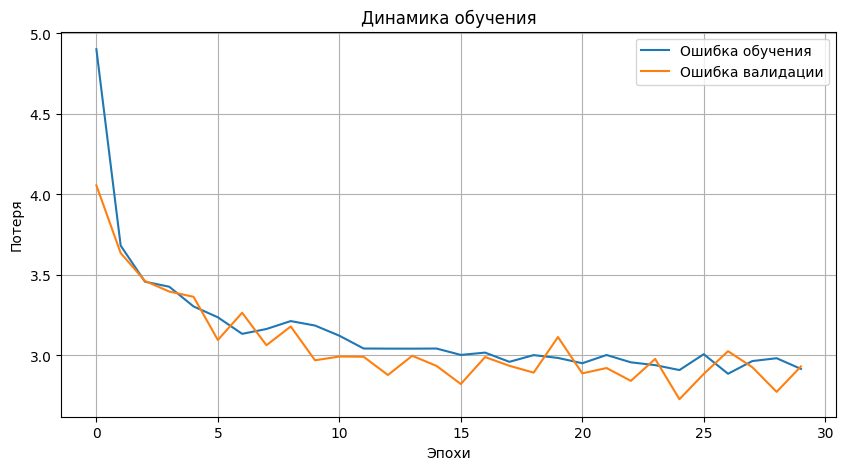

Тестирование модели...
Пример предсказания: a man is slicing

Оценка качества модели на тесте...


Оценка:   0%|          | 0/296 [00:00<?, ?it/s]

BLEU-4: 0.0665
Визуализация предсказаний...


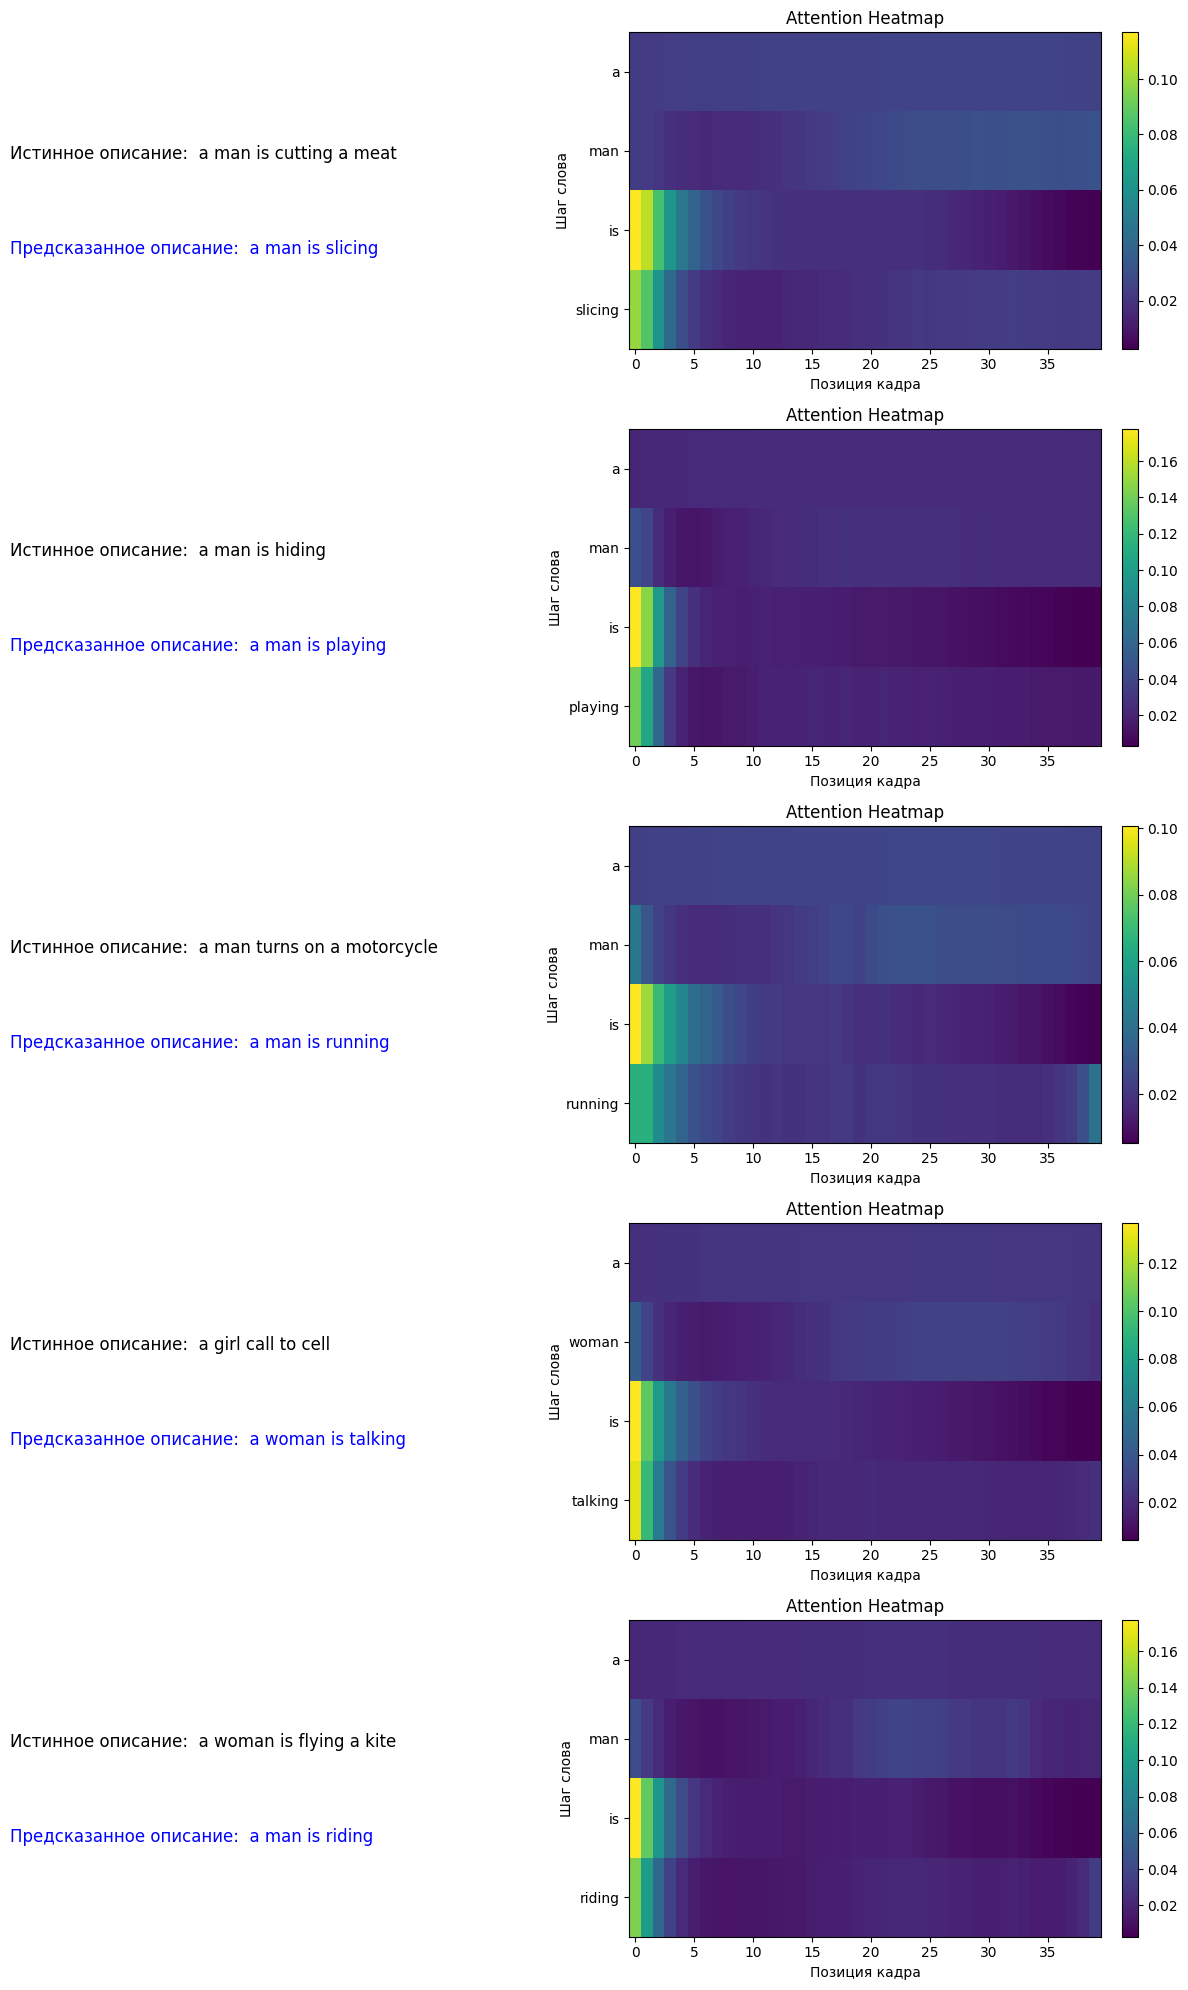

Анализ паттернов внимания на одном примере...


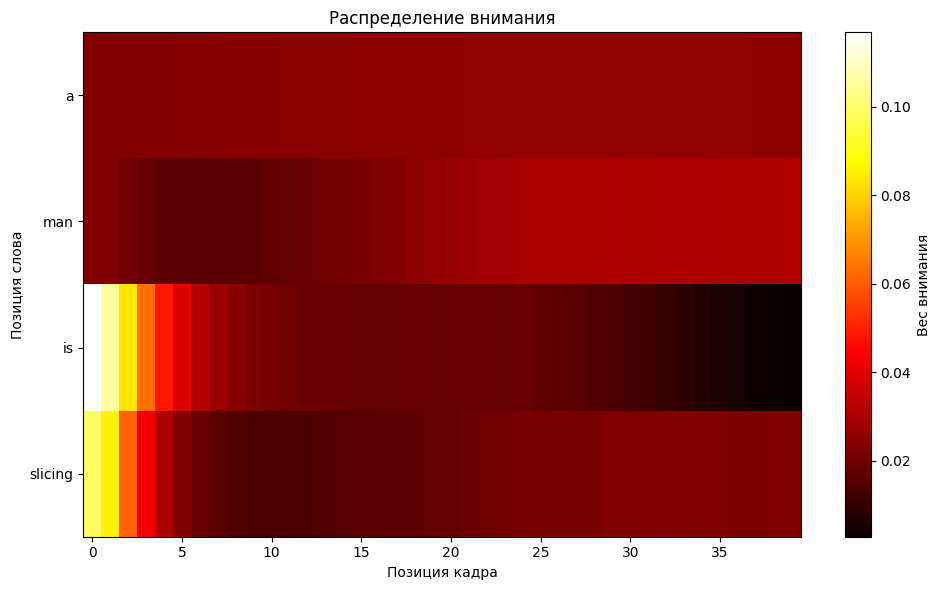

Соответствие слов и кадров:
  'a': кадр 32, вес = 0.0258
  'man': кадр 39, вес = 0.0314
  'is': кадр 0, вес = 0.1168
  'slicing': кадр 0, вес = 0.0987

Самые важные кадры:
  Кадр 0: общий вес = 0.2610
  Кадр 1: общий вес = 0.2368
  Кадр 2: общий вес = 0.1891
  Кадр 3: общий вес = 0.1475
  Кадр 4: общий вес = 0.1196


In [13]:
if __name__ == "__main__":
    main()